In [1]:
conda init

no change     /Users/aesthetic/opt/anaconda3/condabin/conda
no change     /Users/aesthetic/opt/anaconda3/bin/conda
no change     /Users/aesthetic/opt/anaconda3/bin/conda-env
no change     /Users/aesthetic/opt/anaconda3/bin/activate
no change     /Users/aesthetic/opt/anaconda3/bin/deactivate
no change     /Users/aesthetic/opt/anaconda3/etc/profile.d/conda.sh
no change     /Users/aesthetic/opt/anaconda3/etc/fish/conf.d/conda.fish
no change     /Users/aesthetic/opt/anaconda3/shell/condabin/Conda.psm1
no change     /Users/aesthetic/opt/anaconda3/shell/condabin/conda-hook.ps1
no change     /Users/aesthetic/opt/anaconda3/lib/python3.8/site-packages/xontrib/conda.xsh
no change     /Users/aesthetic/opt/anaconda3/etc/profile.d/conda.csh
no change     /Users/aesthetic/.bash_profile
No action taken.

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install alpha_vantage pandas


Note: you may need to restart the kernel to use updated packages.


In [3]:
from alpha_vantage.timeseries import TimeSeries
from pprint import pprint
from alpha_vantage.techindicators import TechIndicators
from datetime import date
from datetime import timedelta

import matplotlib.pyplot as plt 
import sys
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score, classification_report


import numpy as np



In [4]:
# Obtaining stock data from alpha vantage 
sym='AAPL'




ticker_list=['MS', 'BT-A.L', 'TSLA', 'PFE' ]
# 'BT-A.L', 'TSLA', 'PFE'
column_names=['1. open', '2. high', '3. low', '4. close', '5. adjusted close', '6. volume', 
               '7. dividend amount', '8. split coefficient', 'Ticker']
#obtains stock data from the previous day date to 2018-11-29


def stock_data(sym):
    ts = TimeSeries(key='SUXOFAIGXM6HEP9Y', output_format='pandas')
    data, meta_data = ts.get_daily_adjusted(symbol=sym, outputsize='full')
    data_date_changed = data[:'2019-01-01']
    data_date_changed['Ticker']= sym
    return data_date_changed


data_dated = pd.DataFrame(columns = column_names)


for ticker in ticker_list:
    data_dated = data_dated.append(stock_data(ticker), sort=False)


<ipython-input-4-50d4edb1b606>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_date_changed['Ticker']= sym


# Identify Anomalies

In [5]:
print('The shape of our data is:', data_dated.shape)

The shape of our data is: (2123, 9)


In [6]:
data_dated.isna().any()

1. open                 False
2. high                 False
3. low                  False
4. close                False
5. adjusted close       False
6. volume               False
7. dividend amount      False
8. split coefficient    False
Ticker                  False
dtype: bool

In [7]:
data_dated.head()

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,Ticker
2021-02-08,73.64,74.290,73.4000,74.23,74.23,9018095.0,0.0,1.0,MS
2021-02-05,73.10,73.715,72.5503,73.22,73.22,8832176.0,0.0,1.0,MS
2021-02-04,70.93,72.320,70.7670,72.29,72.29,8889354.0,0.0,1.0,MS
2021-02-03,70.87,71.335,70.3100,70.60,70.60,8014333.0,0.0,1.0,MS
2021-02-02,69.12,71.370,69.0200,70.95,70.95,13711152.0,0.0,1.0,MS


In [8]:


%matplotlib inline

# Set the style
plt.style.use('fivethirtyeight')

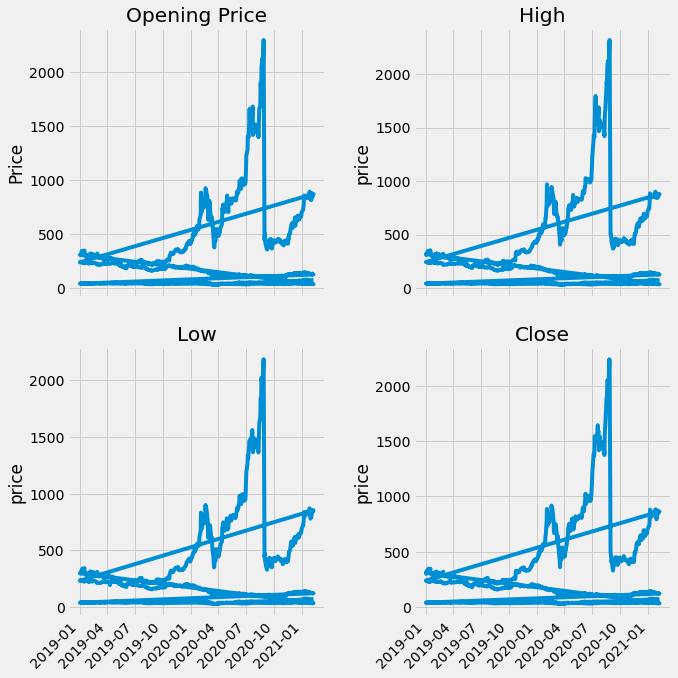

In [9]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize = (10,10))
fig.autofmt_xdate(rotation = 45)

# opening price
ax1.plot(data_dated.index, data_dated['1. open'])
ax1.set_xlabel(''); ax1.set_ylabel('Price'); ax1.set_title('Opening Price')


ax2.plot(data_dated.index, data_dated['2. high'])
ax2.set_xlabel(''); ax2.set_ylabel('price'); ax2.set_title('High')


ax3.plot(data_dated.index, data_dated['3. low'])
ax3.set_xlabel(''); ax3.set_ylabel('price'); ax3.set_title('Low')

ax4.plot(data_dated.index, data_dated['4. close'])
ax4.set_xlabel(''); ax4.set_ylabel('price'); ax4.set_title('Close')


plt.tight_layout(pad=2)


In [10]:
data_dated[data_dated.duplicated()]

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,Ticker


One Hot Encoding 

# data_dated.tail()

In [11]:
data_dated['date']= data_dated.index

In [12]:
data_dated.sort_index(inplace=True)
data_dated.sort_values(by = ['Ticker','date'], inplace = True)


data_dated['change_in_price']= data_dated['4. close'].diff()

In [13]:
mask = data_dated['Ticker'] != data_dated['Ticker'].shift(1)

data_dated['change_in_price']= np.where(mask==True, np.nan, data_dated['change_in_price'])

data_dated[data_dated.isna().any(axis=1)]

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,Ticker,date,change_in_price
2019-01-02,237.00,242.20,233.25,240.00,220.802700,20278421.0,0.0,1.0,BT-A.L,2019-01-02,NaN
2019-01-02,39.02,40.72,38.76,40.40,37.935801,10648013.0,0.0,1.0,MS,2019-01-02,NaN
2019-01-02,43.12,43.50,42.64,43.25,37.587547,25076212.0,0.0,1.0,PFE,2019-01-02,NaN
2019-01-02,306.10,315.13,298.80,310.12,62.024000,11658600.0,0.0,1.0,TSLA,2019-01-02,NaN


In [14]:
data_dated.reset_index(inplace=True)

In [15]:
days_out= 30

data_dated_smoothed = data_dated.groupby(['Ticker'])[['1. open','2. high','3. low','4. close','6. volume']].transform(lambda x: x.ewm(span = days_out).mean())

smoothed_df = pd.concat([data_dated[['Ticker','date']], data_dated_smoothed], axis=1, sort=False)

In [16]:
days_out = 30

smoothed_df['Signal_Flag'] = smoothed_df.groupby('Ticker')['4. close'].transform(lambda x : np.sign(x.diff(days_out)))

smoothed_df.tail(100)

,Ticker,date,1. open,2. high,3. low,4. close,6. volume,Signal_Flag
2023,TSLA,2020-09-16,1000.337131,1035.206512,968.862455,1006.760736,5.610571e+07,-1.0
2024,TSLA,2020-09-17,962.612154,996.663511,932.677787,969.126495,5.743948e+07,-1.0
2025,TSLA,2020-09-18,929.407499,961.459414,900.169543,935.128011,5.930834e+07,-1.0
2026,TSLA,2020-09-21,898.679919,928.828484,868.356669,903.790075,6.254501e+07,-1.0
2027,TSLA,2020-09-22,868.416698,897.146646,839.275600,872.850715,6.364410e+07,-1.0
...,...,...,...,...,...,...,...,...
2118,TSLA,2021-02-02,779.447559,798.172687,763.314185,783.982218,3.704788e+07,1.0
2119,TSLA,2021-02-03,785.742555,803.327998,769.104535,788.544011,3.584114e+07,1.0
2120,TSLA,2021-02-04,790.210777,806.758450,773.253920,792.508268,3.454898e+07,1.0
2121,TSLA,2021-02-05,793.745566,810.501130,777.493667,796.361283,3.351786e+07,1.0


                                                            RSI

In [17]:

# Calculate the 14 day RSI
n = 14

# First make a copy of the data frame twice
up_df, down_df = smoothed_df[['Ticker','Signal_Flag']].copy(), smoothed_df[['Ticker','Signal_Flag']].copy()

# For up days, if the change is less than 0 set to 0.
up_df.loc['Signal_Flag'] = up_df.loc[(up_df['Signal_Flag'] < 0), 'Signal_Flag'] = 0

# For down days, if the change is greater than 0 set to 0.
down_df.loc['Signal_Flag'] = down_df.loc[(down_df['Signal_Flag'] > 0), 'Signal_Flag'] = 0


# We need change in price to be absolute.
down_df['Signal_Flag'] = down_df['Signal_Flag'].abs()
# resetting index 
# down_df.set_index(smoothed_df['date'], inplace=True)

# Calculate the EWMA (Exponential Weighted Moving Average), meaning older values are given less weight compared to newer values.
ewma_up = up_df.groupby('Ticker')['Signal_Flag'].transform(lambda x: x.ewm(span = n).mean())
ewma_down = down_df.groupby('Ticker')['Signal_Flag'].transform(lambda x: x.ewm(span = n).mean())

# Calculate the Relative Strength
relative_strength = ewma_up / ewma_down

# Calculate the Relative Strength Index
relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))

# Add the info to the data frame.

smoothed_df['down_days'] = down_df['Signal_Flag']
smoothed_df['up_days'] = up_df['Signal_Flag']
smoothed_df['RSI'] = relative_strength_index

# Display the head.
smoothed_df.head(5)


,Ticker,date,1. open,2. high,3. low,4. close,6. volume,Signal_Flag,down_days,up_days,RSI
0,BT-A.L,2019-01-02,237.000000,242.200000,233.250000,240.000000,2.027842e+07,NaN,NaN,NaN,NaN
1,BT-A.L,2019-01-03,238.601667,242.406667,235.471667,240.051667,1.702170e+07,NaN,NaN,NaN,NaN
2,BT-A.L,2019-01-04,239.454980,242.226398,235.819752,239.090429,1.789780e+07,NaN,NaN,NaN,NaN
3,BT-A.L,2019-01-07,239.591376,242.164017,236.163139,238.776200,1.723919e+07,NaN,NaN,NaN,NaN
4,BT-A.L,2019-01-08,239.172418,241.421374,234.624361,237.006926,1.935927e+07,NaN,NaN,NaN,NaN


Stoch Oscillator

In [18]:

# Calculate the Stochastic Oscillator
n = 14

# Make a copy of the high and low column.
low_14, high_14 = smoothed_df[['Ticker','3. low']].copy(), smoothed_df[['Ticker','2. high']].copy()

# Group by symbol, then apply the rolling function and grab the Min and Max.
low_14 = low_14.groupby('Ticker')['3. low'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14.groupby('Ticker')['2. high'].transform(lambda x: x.rolling(window = n).max())

# Calculate the Stochastic Oscillator.
k_percent = 100 * ((smoothed_df['4. close'] - low_14) / (high_14 - low_14))

# Add the info to the data frame.
smoothed_df['low_14'] = low_14
smoothed_df['high_14'] = high_14
smoothed_df['k_percent'] = k_percent

# Display the head.
smoothed_df.head(5)

,Ticker,date,1. open,2. high,3. low,4. close,6. volume,Signal_Flag,down_days,up_days,RSI,low_14,high_14,k_percent
0,BT-A.L,2019-01-02,237.000000,242.200000,233.250000,240.000000,2.027842e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BT-A.L,2019-01-03,238.601667,242.406667,235.471667,240.051667,1.702170e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BT-A.L,2019-01-04,239.454980,242.226398,235.819752,239.090429,1.789780e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BT-A.L,2019-01-07,239.591376,242.164017,236.163139,238.776200,1.723919e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BT-A.L,2019-01-08,239.172418,241.421374,234.624361,237.006926,1.935927e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# Calculate the Williams %R
n = 14

# Make a copy of the high and low column.
low_14, high_14 = smoothed_df[['Ticker','3. low']].copy(), smoothed_df[['Ticker','2. high']].copy()

# Group by symbol, then apply the rolling function and grab the Min and Max.
low_14 = low_14.groupby('Ticker')['3. low'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14.groupby('Ticker')['2. high'].transform(lambda x: x.rolling(window = n).max())

# Calculate William %R indicator.
r_percent = ((high_14 - smoothed_df['4. close']) / (high_14 - low_14)) * - 100

# Add the info to the data frame.
smoothed_df['r_percent'] = r_percent

# Display the head.
smoothed_df.head(5)

,Ticker,date,1. open,2. high,3. low,4. close,6. volume,Signal_Flag,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent
0,BT-A.L,2019-01-02,237.000000,242.200000,233.250000,240.000000,2.027842e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BT-A.L,2019-01-03,238.601667,242.406667,235.471667,240.051667,1.702170e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BT-A.L,2019-01-04,239.454980,242.226398,235.819752,239.090429,1.789780e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BT-A.L,2019-01-07,239.591376,242.164017,236.163139,238.776200,1.723919e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BT-A.L,2019-01-08,239.172418,241.421374,234.624361,237.006926,1.935927e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# Calculate the MACD
ema_26 = smoothed_df.groupby('Ticker')['4. close'].transform(lambda x: x.ewm(span = 26).mean())
ema_12 = smoothed_df.groupby('Ticker')['4. close'].transform(lambda x: x.ewm(span = 12).mean())
macd = ema_12 - ema_26

# Calculate the EMA
ema_9_macd = macd.ewm(span = 9).mean()

# Store the data in the data frame.
smoothed_df['MACD'] = macd
smoothed_df['MACD_EMA'] = ema_9_macd

# Print the head.
smoothed_df.head(5)

,Ticker,date,1. open,2. high,3. low,4. close,6. volume,Signal_Flag,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA
0,BT-A.L,2019-01-02,237.000000,242.200000,233.250000,240.000000,2.027842e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
1,BT-A.L,2019-01-03,238.601667,242.406667,235.471667,240.051667,1.702170e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001159,0.000644
2,BT-A.L,2019-01-04,239.454980,242.226398,235.819752,239.090429,1.789780e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.028331,-0.011231
3,BT-A.L,2019-01-07,239.591376,242.164017,236.163139,238.776200,1.723919e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.052394,-0.025175
4,BT-A.L,2019-01-08,239.172418,241.421374,234.624361,237.006926,1.935927e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.134771,-0.057777


In [21]:
# Calculate the Price Rate of Change
n = 9

# Calculate the Rate of Change in the Price, and store it in the Data Frame.
smoothed_df['Price_Rate_Of_Change'] = smoothed_df.groupby('Ticker')['4. close'].transform(lambda x: x.pct_change(periods = n))

# Print the first 30 rows
smoothed_df.head(5)

,Ticker,date,1. open,2. high,3. low,4. close,6. volume,Signal_Flag,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change
0,BT-A.L,2019-01-02,237.000000,242.200000,233.250000,240.000000,2.027842e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
1,BT-A.L,2019-01-03,238.601667,242.406667,235.471667,240.051667,1.702170e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001159,0.000644,NaN
2,BT-A.L,2019-01-04,239.454980,242.226398,235.819752,239.090429,1.789780e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.028331,-0.011231,NaN
3,BT-A.L,2019-01-07,239.591376,242.164017,236.163139,238.776200,1.723919e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.052394,-0.025175,NaN
4,BT-A.L,2019-01-08,239.172418,241.421374,234.624361,237.006926,1.935927e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.134771,-0.057777,NaN


In [22]:
def obv(group):

    # Grab the volume and close column.
    volume = group['6. volume']
    change = group['4. close'].diff()

    # intialize the previous OBV
    prev_obv = 0
    obv_values = []

    # calculate the On Balance Volume
    for i, j in zip(change, volume):

        if i > 0:
            current_obv = prev_obv + j
        elif i < 0:
            current_obv = prev_obv - j
        else:
            current_obv = prev_obv

        # OBV.append(current_OBV)
        prev_obv = current_obv
        obv_values.append(current_obv)
    
    # Return a panda series.
    return pd.Series(obv_values, index = group.index)
        

# apply the function to each group
obv_groups = smoothed_df.groupby('Ticker').apply(obv)

# add to the data frame, but drop the old index, before adding it.
smoothed_df['On Balance Volume'] = obv_groups.reset_index(level=0, drop=True)

# display the data frame.
smoothed_df.tail(30)

,Ticker,date,1. open,2. high,3. low,4. close,6. volume,Signal_Flag,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
2093,TSLA,2020-12-24,586.306112,601.604723,570.031134,591.993167,5.454782e+07,1.0,0.0,1.0,84.439216,504.749390,601.604723,90.076379,-9.923621,19.134037,10.816473,0.088463,9.739879e+07
2094,TSLA,2020-12-28,591.996686,606.752805,575.887190,596.618769,5.306432e+07,1.0,0.0,1.0,86.513987,512.088139,606.752805,89.294806,-10.705194,20.351618,12.723502,0.084623,1.504631e+08
2095,TSLA,2020-12-29,596.448513,610.826818,580.991242,601.094332,5.111894e+07,1.0,0.0,1.0,88.312122,516.985679,610.826818,89.628764,-10.371236,21.430661,14.464934,0.082202,2.015820e+08
2096,TSLA,2020-12-30,601.322802,616.360572,586.627955,607.138569,5.058520e+07,1.0,0.0,1.0,89.870506,520.169828,616.360572,90.412796,-9.587204,22.514003,16.074748,0.084601,2.521672e+08
2097,TSLA,2020-12-31,607.688428,622.964406,593.369378,613.495435,5.052486e+07,1.0,0.0,1.0,91.221105,525.113710,622.964406,90.323042,-9.676958,23.613305,17.582459,0.083949,3.026921e+08
2098,TSLA,2021-01-04,614.899497,630.804760,601.357773,620.997020,5.040314e+07,1.0,0.0,1.0,92.391625,530.603155,630.804760,90.211993,-9.788007,24.803902,19.026748,0.081301,3.530952e+08
2099,TSLA,2021-01-05,621.916304,637.903808,608.960497,628.359148,4.923166e+07,1.0,0.0,1.0,93.406075,536.615855,637.903808,90.576707,-9.423293,26.041332,20.429665,0.084912,4.023269e+08
2100,TSLA,2021-01-06,630.727510,646.684207,618.001755,636.592751,4.893929e+07,1.0,0.0,1.0,94.285265,541.027735,646.684207,90.448805,-9.551195,27.370873,21.817906,0.091690,4.512662e+08
2101,TSLA,2021-01-07,640.205090,657.671678,628.143577,648.169993,4.910443e+07,1.0,0.0,1.0,95.047229,546.090462,657.671678,91.484512,-8.515488,29.024158,23.259157,0.103868,5.003706e+08
2102,TSLA,2021-01-08,654.127342,672.305118,641.707863,663.128058,5.077869e+07,1.0,0.0,1.0,95.707599,551.409787,672.305118,92.409086,-7.590914,31.181943,24.843714,0.120162,5.511493e+08


In [23]:
# We need to remove all rows that have an NaN value.
print('Before NaN Drop we have {} rows and {} columns'.format(smoothed_df.shape[0], smoothed_df.shape[1]))

# Any row that has a `NaN` value will be dropped.
smoothed_df = smoothed_df.dropna()

# Display how much we have left now.
print('After NaN Drop we have {} rows and {} columns'.format(smoothed_df.shape[0], smoothed_df.shape[1]))

# Print the head.
smoothed_df.head()

Before NaN Drop we have 2123 rows and 19 columns
After NaN Drop we have 2003 rows and 19 columns


,Ticker,date,1. open,2. high,3. low,4. close,6. volume,Signal_Flag,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
30,BT-A.L,2019-02-13,232.289871,235.307035,229.783401,232.238146,2.183780e+07,-1.0,1.0,0.0,0.0,229.783401,238.107796,29.488576,-70.511424,-0.590819,-0.429422,-0.010697,-3.204044e+08
31,BT-A.L,2019-02-14,232.093036,235.023035,229.632942,232.004849,2.118490e+07,-1.0,1.0,0.0,0.0,229.632942,238.107796,27.987583,-72.012417,-0.651246,-0.473822,-0.010043,-3.415893e+08
32,BT-A.L,2019-02-15,231.977464,234.887150,229.641435,231.946459,2.137936e+07,-1.0,1.0,0.0,0.0,229.632942,238.107796,27.298600,-72.701400,-0.695278,-0.518141,-0.009059,-3.629687e+08
33,BT-A.L,2019-02-18,231.910715,234.902469,229.742809,232.022282,2.064604e+07,-1.0,1.0,0.0,0.0,229.632942,237.960877,28.690665,-71.309335,-0.716035,-0.557740,-0.008696,-3.423227e+08
34,BT-A.L,2019-02-19,232.020678,234.920152,229.864767,232.020690,2.014112e+07,-1.0,1.0,0.0,0.0,229.632942,237.960877,28.671551,-71.328449,-0.724136,-0.591033,-0.008169,-3.624638e+08


In [24]:
# One-hot encode the data using pandas get_dummies
smoothed_df = pd.get_dummies(smoothed_df)

# Labels are the values we want to predict
labels = np.array(smoothed_df['Signal_Flag'])


# Remove the labels from the features
# axis 1 refers to the columns
smoothed_df= smoothed_df.drop('Signal_Flag', axis = 1)


# Saving feature names for later use
smoothed_df_list = list(smoothed_df.columns)

In [25]:
smoothed_df.head(10)

,date,1. open,2. high,3. low,4. close,6. volume,down_days,up_days,RSI,low_14,...,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Ticker_BT-A.L,Ticker_MS,Ticker_PFE,Ticker_TSLA
30,2019-02-13,232.289871,235.307035,229.783401,232.238146,2.183780e+07,1.0,0.0,0.0,229.783401,...,29.488576,-70.511424,-0.590819,-0.429422,-0.010697,-3.204044e+08,1,0,0,0
31,2019-02-14,232.093036,235.023035,229.632942,232.004849,2.118490e+07,1.0,0.0,0.0,229.632942,...,27.987583,-72.012417,-0.651246,-0.473822,-0.010043,-3.415893e+08,1,0,0,0
32,2019-02-15,231.977464,234.887150,229.641435,231.946459,2.137936e+07,1.0,0.0,0.0,229.632942,...,27.298600,-72.701400,-0.695278,-0.518141,-0.009059,-3.629687e+08,1,0,0,0
33,2019-02-18,231.910715,234.902469,229.742809,232.022282,2.064604e+07,1.0,0.0,0.0,229.632942,...,28.690665,-71.309335,-0.716035,-0.557740,-0.008696,-3.423227e+08,1,0,0,0
34,2019-02-19,232.020678,234.920152,229.864767,232.020690,2.014112e+07,1.0,0.0,0.0,229.632942,...,28.671551,-71.328449,-0.724136,-0.591033,-0.008169,-3.624638e+08,1,0,0,0
35,2019-02-20,231.990832,234.805208,229.773915,231.831214,2.100651e+07,1.0,0.0,0.0,229.632942,...,27.753568,-72.246432,-0.736383,-0.620112,-0.007312,-3.834703e+08,1,0,0,0
36,2019-02-21,231.878689,234.568688,229.604314,231.765570,2.140771e+07,1.0,0.0,0.0,229.604314,...,28.477490,-71.522510,-0.742451,-0.644586,-0.005778,-4.048780e+08,1,0,0,0
37,2019-02-22,231.775071,234.350148,229.463863,231.505204,2.120321e+07,1.0,0.0,0.0,229.463863,...,26.988039,-73.011961,-0.758412,-0.667356,-0.005717,-4.260812e+08,1,0,0,0
38,2019-02-25,231.546841,234.047069,229.239899,231.219124,2.098182e+07,1.0,0.0,0.0,229.239899,...,25.414321,-74.585679,-0.783969,-0.690683,-0.005340,-4.470630e+08,1,0,0,0
39,2019-02-26,230.850308,233.315856,228.526515,230.441318,2.153023e+07,1.0,0.0,0.0,228.526515,...,23.204755,-76.795245,-0.854391,-0.723429,-0.007737,-4.685933e+08,1,0,0,0


In [26]:
# Grab our X & Y Columns.
X_Cols = smoothed_df[['RSI','k_percent']]
# Y_Cols = smoothed_df['Signal_Flag']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, labels, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)

# Fit the data to the model
rand_frst_clf.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf.predict(X_test)

In [27]:
# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  97.60479041916167


In [28]:
# *****************************Technical Indicators*******************************************************************

In [29]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.984064,0.968627,0.976285,255.000000
Up Day,0.968000,0.983740,0.975806,246.000000
accuracy,0.976048,0.976048,0.976048,0.976048
macro avg,0.976032,0.976184,0.976046,501.000000
weighted avg,0.976176,0.976048,0.976050,501.000000


Accuracy: 0.9760479041916168
Percision: 0.968
Recall: 0.983739837398374
Specificity: 0.9686274509803922


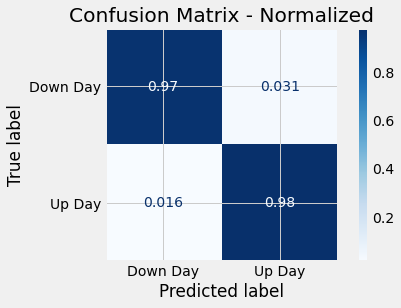

In [30]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

rf_matrix = confusion_matrix(y_test, y_pred)

true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
percision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

print('Accuracy: {}'.format(float(accuracy)))
print('Percision: {}'.format(float(percision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))

disp = plot_confusion_matrix(rand_frst_clf, X_test, y_test, display_labels = ['Down Day', 'Up Day'], normalize = 'true', cmap=plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix - Normalized')
plt.show()

In [31]:
 # Calculate feature importance and store in pandas series
feature_imp = pd.Series(rand_frst_clf.feature_importances_, index=X_Cols.columns).sort_values(ascending=False)
feature_imp

RSI          0.672083
k_percent    0.327917
dtype: float64

Text(0.5, 1.0, 'Random Forest: Feature Importance Graph')

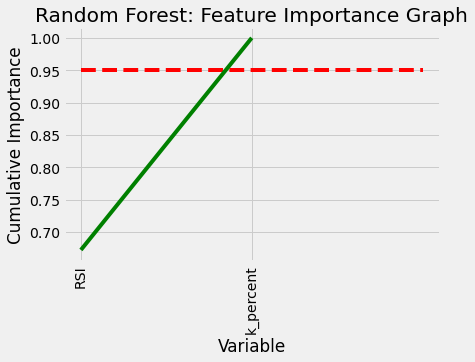

In [32]:
# store the values in a list to plot.
x_values = list(range(len(rand_frst_clf.feature_importances_)))

# Cumulative importances
cumulative_importances = np.cumsum(feature_imp.values)

# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')

# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin = 0, xmax = len(feature_imp), color = 'r', linestyles = 'dashed')

# Format x ticks and labels
plt.xticks(x_values, feature_imp.index, rotation = 'vertical')

# Axis labels and title
plt.xlabel('Variable')
plt.ylabel('Cumulative Importance')
plt.title('Random Forest: Feature Importance Graph')

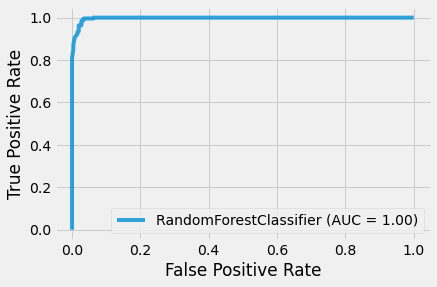

In [33]:

# Create an ROC Curve plot.
rfc_disp = plot_roc_curve(rand_frst_clf, X_test, y_test, alpha = 0.8)
plt.show()

In [34]:
print('Random Forest Out-Of-Bag Error Score: {}'.format(rand_frst_clf.oob_score_))

Random Forest Out-Of-Bag Error Score: 0.9806924101198402


In [35]:
# Number of trees in random forest
# Number of trees is not a parameter that should be tuned, but just set large enough usually. There is no risk of overfitting in random forest with growing number of # trees, as they are trained independently from each other. 
n_estimators = list(range(200, 2000, 200))

# Number of features to consider at every split
max_features = ['auto', 'sqrt', None, 'log2']

# Maximum number of levels in tree
# Max depth is a parameter that most of the times should be set as high as possible, but possibly better performance can be achieved by setting it lower.
max_depth = list(range(10, 110, 10))
max_depth.append(None)

# Minimum number of samples required to split a node
# Higher values prevent a model from learning relations which might be highly specific to the particular sample selected for a tree. Too high values can also lead to # under-fitting hence depending on the level of underfitting or overfitting, you can tune the values for min_samples_split.
min_samples_split = [2, 5, 10, 20, 30, 40]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 7, 12, 14, 16 ,20]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800], 'max_features': ['auto', 'sqrt', None, 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [2, 5, 10, 20, 30, 40], 'min_samples_leaf': [1, 2, 7, 12, 14, 16, 20], 'bootstrap': [True, False]}


In [36]:
# New Random Forest Classifier to house optimal parameters
rf = RandomForestClassifier()

# Specfiy the details of our Randomized Search
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.9min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt', None,
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 7, 12, 14,
                                                             16, 20],
                                        'min_samples_split': [2, 5, 10, 20, 30,
                                                              40],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800]},
          

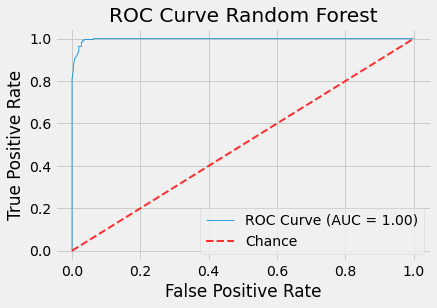

In [37]:
'''
    ROC CURVE
'''

fig, ax = plt.subplots()

# Create an ROC Curve plot.
rfc_disp = plot_roc_curve(rand_frst_clf, X_test, y_test, alpha = 0.8, name='ROC Curve', lw=1, ax=ax)

# Add our Chance Line
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

# Make it look pretty.
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="ROC Curve Random Forest")

# Add the legend to the plot
ax.legend(loc="lower right")

plt.show()